# Decompose the SSH into manometric and steric components
## $\eta = \eta_m + \eta_s = \frac{p_b}{\rho_0 g} - \frac{1}{\rho_0}\int_{-H}^0{\rho'}dz $

In [23]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea

from scipy.stats import linregress
import fsspec
import zarr

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import gsw

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [25]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [26]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [27]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')
# mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_snap_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [28]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ICE_FRONT_FLUX_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ICE_SHELF_FLUX_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_ADV_TEND_X_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_ADV_TEND_Y_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_DISS_TEND_X_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_DISS_TEND_Y_mon_me

In [29]:
# MZZ files have been downloaded. 
# select the SSH dataset
TS_file = mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json'
DEN_file = mzz_local_directory / 'OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json'
PRE_file = mzz_local_directory / 'OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json'
SSH_file = mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json'

print(TS_file)
print(DEN_file)
print(PRE_file)
print(SSH_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json


## load grid

In [30]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
access_mode = 'download'

# download root (parent) directory
grid_fnm = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_grid = xr.open_dataset(grid_fnm)
ds_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

# 1. read data (all times), SSH, pressure, density, T/S

In [31]:
fs_TS = fsspec.filesystem("reference",     
                       fo=str(TS_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_TS.asynchronous = True
store = zarr.storage.FsspecStore(fs_TS)
ds_TS = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

# 
fs_DEN = fsspec.filesystem("reference",     
                       fo=str(DEN_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_DEN.asynchronous = True
store = zarr.storage.FsspecStore(fs_DEN)
ds_DEN = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_PRE = fsspec.filesystem("reference",     
                       fo=str(PRE_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_PRE.asynchronous = True
store = zarr.storage.FsspecStore(fs_PRE)
ds_PRE = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 



fs_SSH = fsspec.filesystem("reference",     
                       fo=str(SSH_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_SSH.asynchronous = True
store = zarr.storage.FsspecStore(fs_SSH)
ds_SSH = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

In [32]:
# ds_TS
ds_PRE
ds_DEN
ds_TS.time

itime = ((ds_PRE.time >= np.array(datetime.datetime(1993,1,1)).astype('datetime64[ns]')) & 
         (ds_PRE.time <= np.array(datetime.datetime(2000,12,31)).astype('datetime64[ns]')))

In [33]:
ds_SSH.time[itime]
eta = ds_SSH.SSH[itime,:,:,:].compute()
ds_SSH
eta.time

<xarray.DataArray 'time' (time: 96)> Size: 768B
array(['1993-01-16T12:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-16T12:00:00.000000000', '1993-04-16T00:00:00.000000000',
       '1993-05-16T12:00:00.000000000', '1993-06-16T00:00:00.000000000',
       '1993-07-16T12:00:00.000000000', '1993-08-16T12:00:00.000000000',
       '1993-09-16T00:00:00.000000000', '1993-10-16T12:00:00.000000000',
       '1993-11-16T00:00:00.000000000', '1993-12-16T12:00:00.000000000',
       '1994-01-16T12:00:00.000000000', '1994-02-15T00:00:00.000000000',
       '1994-03-16T12:00:00.000000000', '1994-04-16T00:00:00.000000000',
       '1994-05-16T12:00:00.000000000', '1994-06-16T00:00:00.000000000',
       '1994-07-16T12:00:00.000000000', '1994-08-16T12:00:00.000000000',
       '1994-09-16T00:00:00.000000000', '1994-10-16T12:00:00.000000000',
       '1994-11-16T00:00:00.000000000', '1994-12-16T12:00:00.000000000',
       '1995-01-16T12:00:00.000000000', '1995-02-15T00:00:00.000000000',
       '1995-03-16T12:00:00.000000000', '1995-04-16T00:00:00.000000000',
       '1995-05-16T12:00:00.000000000', '1995-06-16T00:00:00.000000000',
       '1995-07-16T12:00:00.000000000', '1995-08-16T12:00:00.000000000',
       '1995-09-16T00:00:00.000000000', '1995-10-16T12:00:00.000000000',
       '1995-11-16T00:00:00.000000000', '1995-12-16T12:00:00.000000000',
       '1996-01-16T12:00:00.000000000', '1996-02-15T12:00:00.000000000',
       '1996-03-16T12:00:00.000000000', '1996-04-16T00:00:00.000000000',
       '1996-05-16T12:00:00.000000000', '1996-06-16T00:00:00.000000000',
       '1996-07-16T12:00:00.000000000', '1996-08-16T12:00:00.000000000',
       '1996-09-16T00:00:00.000000000', '1996-10-16T12:00:00.000000000',
       '1996-11-16T00:00:00.000000000', '1996-12-16T12:00:00.000000000',
       '1997-01-16T12:00:00.000000000', '1997-02-15T00:00:00.000000000',
       '1997-03-16T12:00:00.000000000', '1997-04-16T00:00:00.000000000',
       '1997-05-16T12:00:00.000000000', '1997-06-16T00:00:00.000000000',
       '1997-07-16T12:00:00.000000000', '1997-08-16T12:00:00.000000000',
       '1997-09-16T00:00:00.000000000', '1997-10-16T12:00:00.000000000',
       '1997-11-16T00:00:00.000000000', '1997-12-16T12:00:00.000000000',
       '1998-01-16T12:00:00.000000000', '1998-02-15T00:00:00.000000000',
       '1998-03-16T12:00:00.000000000', '1998-04-16T00:00:00.000000000',
       '1998-05-16T12:00:00.000000000', '1998-06-16T00:00:00.000000000',
       '1998-07-16T12:00:00.000000000', '1998-08-16T12:00:00.000000000',
       '1998-09-16T00:00:00.000000000', '1998-10-16T12:00:00.000000000',
       '1998-11-16T00:00:00.000000000', '1998-12-16T12:00:00.000000000',
       '1999-01-16T12:00:00.000000000', '1999-02-15T00:00:00.000000000',
       '1999-03-16T12:00:00.000000000', '1999-04-16T00:00:00.000000000',
       '1999-05-16T12:00:00.000000000', '1999-06-16T00:00:00.000000000',
       '1999-07-16T12:00:00.000000000', '1999-08-16T12:00:00.000000000',
       '1999-09-16T00:00:00.000000000', '1999-10-16T12:00:00.000000000',
       '1999-11-16T00:00:00.000000000', '1999-12-16T12:00:00.000000000',
       '2000-01-16T12:00:00.000000000', '2000-02-15T12:00:00.000000000',
       '2000-03-16T12:00:00.000000000', '2000-04-16T00:00:00.000000000',
       '2000-05-16T12:00:00.000000000', '2000-06-16T00:00:00.000000000',
       '2000-07-16T12:00:00.000000000', '2000-08-16T12:00:00.000000000',
       '2000-09-16T00:00:00.000000000', '2000-10-16T12:00:00.000000000',
       '2000-11-16T00:00:00.000000000', '2000-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 768B 1993-01-16T12:00:00 ... 2000-12-16T12...
Attributes:
    axis:                   T
    bounds:                 time_bnds
    comment:                 
    coverage_content_type:  coordinate
    long_name:              center time of averaging period
    standard_name:          time

# 2. manometric component $\eta_m = \frac{p_b}{\rho_0 g}$

In [34]:
g = 9.81
rhoConst = 1029.
p_atm = 101325.   # atmospheric pressure at sea surface, in Pa

# ---- botome pressure
pb = ds_PRE.OBP[itime,:,:,:].compute()
eta_m = pb

In [35]:
ds_PRE
# eta

<xarray.Dataset> Size: 713MB
Dimensions:    (time: 336, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90,
                nv: 2)
Coordinates: (12/13)
  * time       (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    ...         ...
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(2, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    OBP        (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPAnoma   (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPGMAP    (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPGMAPA   (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    PHIBOT     (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Ocean Bottom Pressure - Monthly Mean l...
    uuid:                         7bc60038-2c35-11f0-b9c7-0a58a9feac02

## plot $\eta$ and $\eta_m$

Text(0.5, 1.0, '\\eta')

<Figure size 1400x600 with 0 Axes>

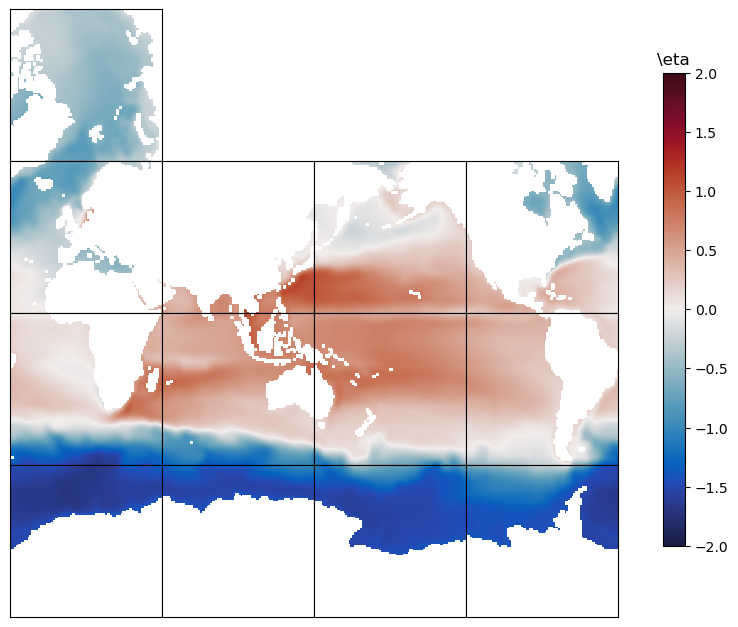

In [36]:

plt.figure(figsize=[14,6]);
ecco.plot_tiles(eta[0,:,:,:], show_colorbar=True, 
                cmin=-2, cmax=2, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=False);
plt.title('\eta')

Text(0.5, 1.0, '$\\eta_m$')

<Figure size 1400x600 with 0 Axes>

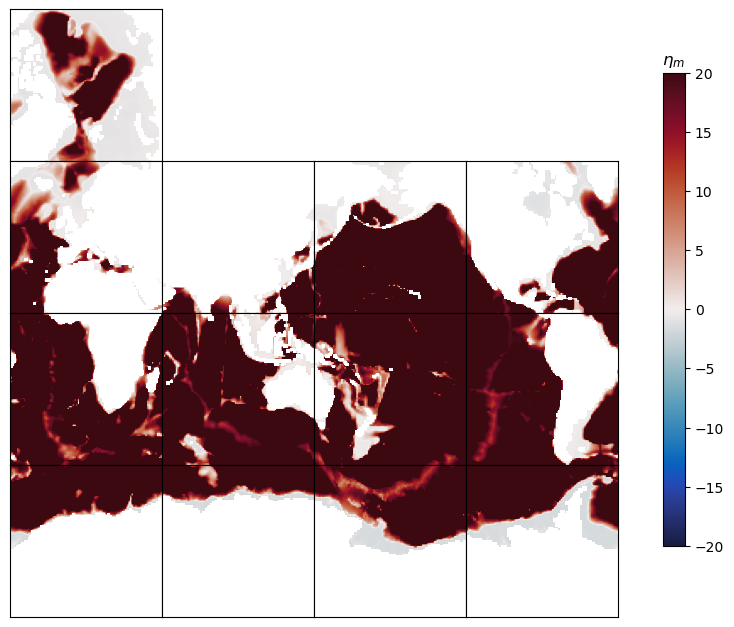

In [37]:
# detam = eta_m[2,:,:,:] - eta_m[1,:,:,:]

plt.figure(figsize=[14,6]);
ecco.plot_tiles(eta_m[0,:,:,:], show_colorbar=True, 
                cmin=-20, cmax=20, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
                show_tile_labels=False);
plt.title('$\eta_m$')


# 3. steric component $- \frac{1}{\rho_0}\int_{-H}^0{\rho'}dz $

## Specific volume anomaly

In [38]:
# ds_DEN.PHIHYDcR
g = 9.81
rhoConst = 1029.
p_atm = 101325.   # atmospheric pressure at sea surface, in Pa

# at k=0, pressure at 5m depth
press = (ds_DEN.PHIHYDcR[itime,:,:,:] + (g*(-ds_grid.Z)))*rhoConst   # pressure

# removes the atmosphere pressure, but still at k=0, pressure is pressure caused by the water at 5m
press_sea = press - p_atm    # pressure minus mean atmospheric pressure

dens = ds_DEN.RHOAnoma[itime,:,:,:] + rhoConst   # in-situ density

# compute standard specific volume and anomalies
S_Ar = 35.16504    # absolute salinity standard for spec. vol., notated as SSO in GSW documentation
T_Cr = 0.    # conservative temperature standard

specvol_standard = gsw.density.specvol(S_Ar,T_Cr,(1.e-4)*press_sea.values)
specvol_anom = 1/dens - specvol_standard

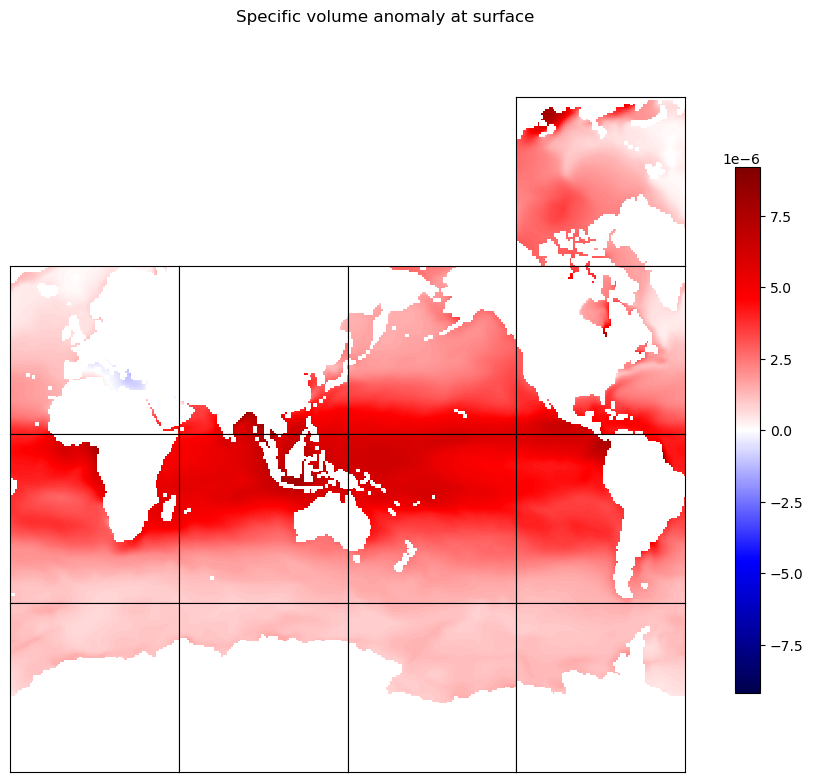

In [39]:
# # plot global tiles map of specific volume anomaly in topmost layer (k=0)
specvol_anom

# k index (depth level) to plot
k_plot = 0

# 13 tiles map
curr_obj = ecco.plot_tiles(specvol_anom.isel(time=0, k=k_plot).squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
curr_fig.suptitle('Specific volume anomaly at surface')

plt.show()

In [21]:
# pressure reference level to compute steric height
# (in units of dbar, minus 10.1325 dbar atmospheric pressure)
p_r_sea_dbar = 2000.

# # integrate vertically in pressure coordinates

p_r = ((1.e4)*p_r_sea_dbar) + p_atm

# compute pressure at z = 0 (not exactly the ocean surface)
press_z0 = press.isel(k=[0]) - (0.5*dens.isel(k=[0])*g*ds_grid.drF.isel(k=[0]))
press_z0.Z.values = np.array([ds_grid.Zl[0].values,])
# integrate hydrostatic balance downward to get pressure at bottom of grid cells
press_ku = press_z0.values + (dens*g*ds_grid.drF).cumsum("k")
press_ku.Z.values = ds_grid.Zu.values
# create array with pressure at top of grid cells
press_kl = xr.concat([press_z0,press_ku.isel(k=np.arange(len(ds_grid.k) - 1))],dim="k")
press_kl = press_kl.assign_coords(k=ds_grid.k.values)

In [22]:
# # compute steric height anomaly at given pressure p_top_sea_dbar, relative to p_r_sea_dbar
p_top_sea_dbar = 0.

p_top = ((1.e4)*p_top_sea_dbar) + p_atm

# compute dp for this integration
dp_integrate =  np.fmax(press_kl,p_top*np.ones(press_kl.shape)) - \
                np.fmin(press_ku,p_r*np.ones(press_ku.shape))
# allow integration above z=0 if p_top is less than p at z=0
p_top_above_z0_mask = (p_top - press_kl.isel(k=0).values < 0)
dp_integrate.isel(k=0).values[p_top_above_z0_mask] = \
                                (p_top - press_ku[:,0,:,:,:].values)[p_top_above_z0_mask]
dp_integrate.values[dp_integrate.values > 0] = 0
steric_hgt_anom = (-(specvol_anom/g)*dp_integrate).sum("k")


KeyboardInterrupt: 

In [ ]:
steric_hgt_anom

# # # plot global tiles map of steric height at sea level pressure, i.e. sea pressure = 0 dbar
# # # relative to p_r_sea_dbar

# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_anom[0,:,:,:],\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,cmin=-5,cmax=5)
curr_fig = curr_obj[0]
curr_fig.suptitle('Steric height anomaly [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

In [ ]:
# load land mask (a boolean array) from grid parameters
land_mask = ~ds_grid.maskC

# surface land mask
land_mask_surf = land_mask.isel(k=0)

# mask out areas where sea pressure never reaches the reference pressure
too_shallow_mask = (press_ku.isel(k=-1) < p_r)

# steric height anomaly global mean, excluding masked areas
unmasked = (~land_mask_surf)*(~too_shallow_mask)
steric_hgt_globmean = np.sum(unmasked*ds_grid.rA*eta_s)\
                        /np.sum(unmasked*ds_grid.rA)
steric_hgt_minus_globmean = steric_hgt_anom - steric_hgt_globmean


# function to plot a mask in ECCO tiles plots
def plot_mask_ecco_tiles(mask,color):
    """
    Plot mask in global ECCO tiles plot on current axes, 
    given 2-D mask (xarray DataArray) and color (a string, RGB tuple or 3-element NumPy array).
    """
    # loop through tiles to add mask
    tile_order = np.array([-1,-1,-1,6, \
                             2,5,7,10,  \
                             1,4,8,11, \
                             0,3,9,12])
    for idx,curr_ax in enumerate(curr_fig.get_axes()):
        if len(curr_ax.get_images()) > 0:
            # plot land mask
            array_plot = mask.isel(tile=tile_order[idx]).squeeze()
            if tile_order[idx] == 6:
                array_plot = np.rot90(array_plot,2)
            elif tile_order[idx] > 6:
                array_plot = np.rot90(array_plot)
            # plot_mask(array_plot,ax=curr_ax,color=color)

# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask

# add title
curr_fig.suptitle('Steric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

plt.show()

## plot SSH

In [ ]:
# remove global mean from SSH
SSH_globmean = np.sum((ds_grid.maskC.isel(k=0))*(ds_grid.rA)*eta)\
                    /np.sum((ds_grid.maskC.isel(k=0))*(ds_grid.rA))
SSH_minus_globmean = eta - SSH_globmean


# plot steric height and SSH minus respective global means

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2,1)

curr_fig = subfigs[0]
# 13 tiles map
curr_obj = ecco.plot_tiles(steric_hgt_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Steric height minus global mean [m] at ' + str(int(p_top_sea_dbar)) + ' dbar,\n'\
                 + 'relative to ' + str(int(p_r_sea_dbar)) + ' dbar')

curr_fig = subfigs[1]
# 13 tiles map
curr_obj = ecco.plot_tiles(SSH_minus_globmean.squeeze(),\
                            cmap='seismic',show_colorbar=True,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10,\
                            cmin=-2.,cmax=2.)
curr_fig = curr_obj[0]
plot_mask_ecco_tiles(land_mask_surf,np.zeros(3,))    # plot land mask
plot_mask_ecco_tiles(too_shallow_mask,np.array([0.5,0.5,0.5]))    # plot too-shallow mask
curr_fig.suptitle('Sea surface height minus global mean [m],\n' + \
                    'with bathymetry shallower than ' + str(int(p_r_sea_dbar)) + ' dbar masked')

plt.show()

## calc area mean $\eta$

In [ ]:
eta
eta_m
steric_hgt_anom

In [ ]:

# fig, axs = plt.subplots(1, 3, figsize=(10, 4))  # axs is an array of Axes objects
# ax1 = plt.subplot(2,1,1)
# p1 = ax1.pcolormesh(mht['lat'],depth,fld,cmap=cmap,vmin=cmin,vmax=cmax)
# plt.grid()

plt.subplot(2, 2, 1)
# p1 = ax1.pcolormesh(mht['lat'],depth,eta.isel(tile=10,time=0),cmap=cmap,vmin=cmin,vmax=cmax)
eta.isel(tile=10,time=0).plot(cmap='RdBu', vmin=-2,vmax=2)

plt.subplot(2, 2, 2)
eta_m.isel(tile=10,time=0).plot(cmap='RdBu', vmin=-2,vmax=2)

plt.subplot(2, 2, 3)
steric_hgt_anom.isel(tile=10,time=0).plot(cmap='RdBu', vmin=-2,vmax=2)

plt.tight_layout()  # Avoid overlapping labels
plt.show()

In [ ]:
eta_anom = eta - eta[0,:,:,:]
etam_anom = eta_m - eta_m[0,:,:,:]
etas_anom = steric_hgt_anom - steric_hgt_anom[0,:,:,:]
res = eta_anom - etam_anom - etas_anom

#--- area mean 
# eta_a_w = eta_anom * ds_grid.rA / ds_grid.rA.sum()
# weights = np.cos(np.deg2rad(data['lat']))

eta_mn = eta_anom.weighted(ds_grid.rA).mean(dim=("j", "i"))
etam_mn = etam_anom.weighted(ds_grid.rA).mean(dim=("j", "i"))
etas_mn = etas_anom.weighted(ds_grid.rA).mean(dim=("j", "i"))
res = eta_mn - etam_mn - etas_mn

In [187]:
etas_mn.compute()
etas_mn

<xarray.DataArray (time: 300, tile: 13)> Size: 31kB
dask.array<truediv, shape=(300, 13), dtype=float64, chunksize=(2, 7), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2017-12-16T12:...
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12

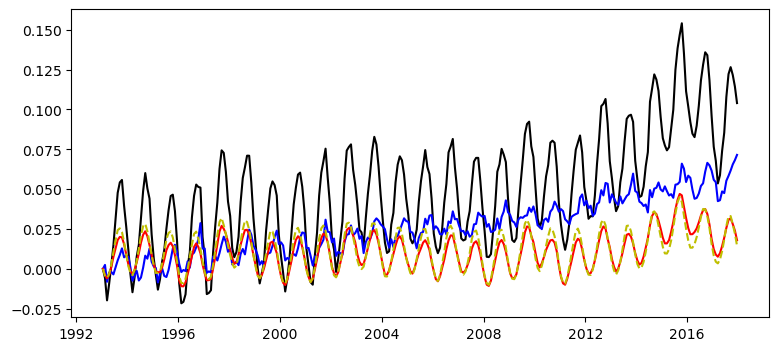

In [194]:
# ------ plot
itile = 10

plt.figure(figsize=(9,4))
plt.plot(eta_mn['time'], eta_mn[:,itile], label='$\eta$', color='k')
plt.plot(etam_mn['time'], etam_mn[:,itile], label='$\eta_m$', color='b')
plt.plot(etas_mn['time'], etas_mn[:,itile], label='$\eta_s$', color='r')
plt.plot(res['time'], res[:,itile], label='$\eta - \eta_m - \eta_s$', color='y', linestyle='--')


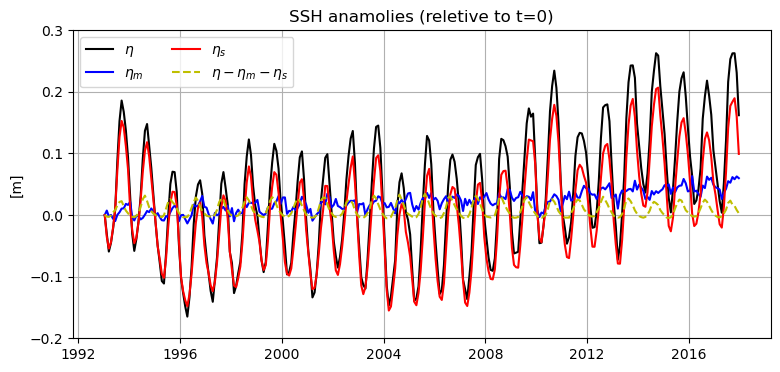

In [200]:
res = eta_anom - etam_anom - etas_anom

plt.figure(figsize=(9,4))
plt.plot(eta_anom['time'], eta_anom[:,10,66,55], label='$\eta$', color='k')

# plt.figure(figsize=(12,6))
plt.plot(etam_anom['time'], etam_anom[:,10,66,55], label='$\eta_m$', color='b')

# plt.figure(figsize=(12,6))
plt.plot(etas_anom['time'], etas_anom[:,10,66,55], label='$\eta_s$', color='r')

plt.plot(res['time'], res[:,10,66,55], label='$\eta - \eta_m - \eta_s$', color='y', linestyle='--')

# plt.xlabel('')
plt.ylim(-.2, .3)
plt.ylabel('[m]')
plt.legend(ncol=2)
plt.grid(True) 
plt.title('SSH anamolies (reletive to t=0)')

# plt.savefig("/efs_ecco/ylu/ssh_ms_comp_test.png", dpi=600, bbox_inches='tight')

In [124]:
eta[0,10,66,55].compute()

<xarray.DataArray 'SSH' ()> Size: 4B
array(-0.32518306, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 1993-01-16T12:00:00
    XC       float32 4B -61.5
    YC       float32 4B 40.69
    i        int32 4B 55
    j        int32 4B 66
    tile     int32 4B 10
Attributes:
    comment:                Also known as ocean dynamic sea level.  The local...
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height
    units:                  m
    valid_max:              1.175236463546753
    valid_min:              -1.7391213178634644

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B -10.0 -20.0 ... -6.134e+03
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

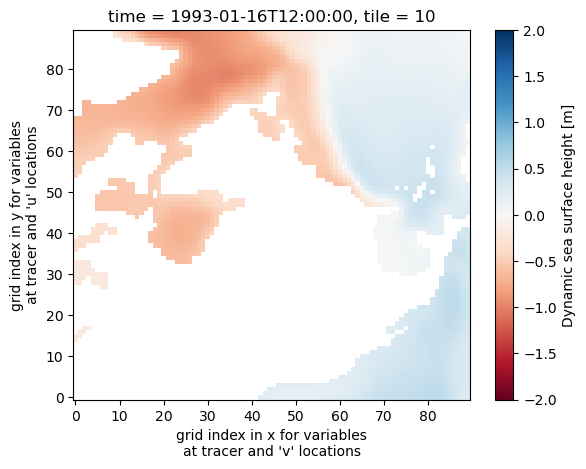

In [201]:
eta.isel(tile=10,time=0).plot(cmap='RdBu', vmin=-2,vmax=2)
